<a href="https://colab.research.google.com/github/AlekseiMikhalev/Data-Science-Projects/blob/master/ULMFiT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__Template for ULMFiT sentiment analysis__

In [0]:
#Importing Libraries 

from fastai.metrics import accuracy #explain why?
from fastai.text import * #explain why?
from fastai import * #explain why?
import gc #explain why?
import os #explain why?
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np #linear algebra
import matplotlib.pyplot as plt #library for visualization 

In [6]:
#Open the dataset and explore it
tweets = pd.read_csv('/content/Tweets.csv')
print('Shape: ', tweets.shape) #check the shape of the dataframe
tweets.head()

Shape:  (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
#Let's check missing data in each column
def check_missing_data(df):
  # check for any missing data in the df (sort in descending order)
  return df.isnull() | df.isna().sum().sort_values(ascending=False)

In [8]:
check_missing_data(tweets)

negativereason_gold             14608
airline_sentiment_gold          14600
tweet_coord                     13621
negativereason                   5462
user_timezone                    4820
tweet_location                   4733
negativereason_confidence        4118
tweet_created                       0
text                                0
retweet_count                       0
name                                0
airline                             0
airline_sentiment_confidence        0
airline_sentiment                   0
tweet_id                            0
dtype: int64

In [13]:
#Calculate the percentage of null values in each column and sort in descending order
print("The percentage of null or na values in the dataset")
((tweets.isnull() | tweets.isna()).sum() * 100 / tweets.index.size).round(2).sort_values(ascending=False)

The percentage of null or na values in the dataset


negativereason_gold             99.78
airline_sentiment_gold          99.73
tweet_coord                     93.04
negativereason                  37.31
user_timezone                   32.92
tweet_location                  32.33
negativereason_confidence       28.13
tweet_created                    0.00
text                             0.00
retweet_count                    0.00
name                             0.00
airline                          0.00
airline_sentiment_confidence     0.00
airline_sentiment                0.00
tweet_id                         0.00
dtype: float64

In [0]:
#Droping top 3 columns with the highest percentage of missing values
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

###__Data visualization__

*Visualize the total number of tweets per each airlines*

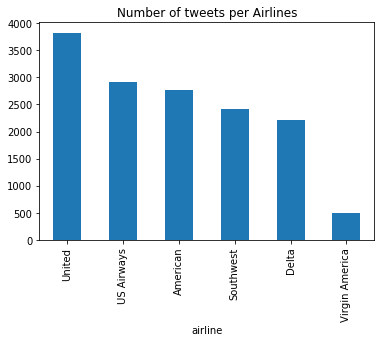

In [16]:
tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Number of tweets per Airlines')
plt.show()

*Tweet sentiments per each airlines*

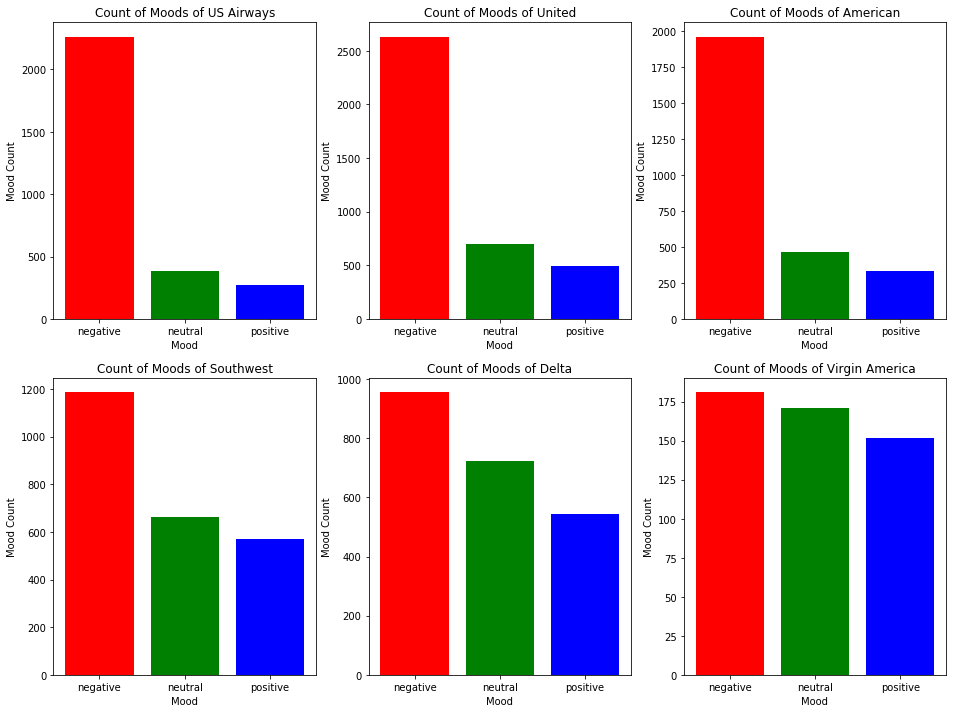

In [17]:
#Let's plot bar charts that show the number of tweets in each sentiment group per airlines
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

plt.figure(1,figsize=(16, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=tweets[tweets['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

###__Wordclouds__ of the __Positive__, __Negative__, __Neutral__ - airline_sentiment

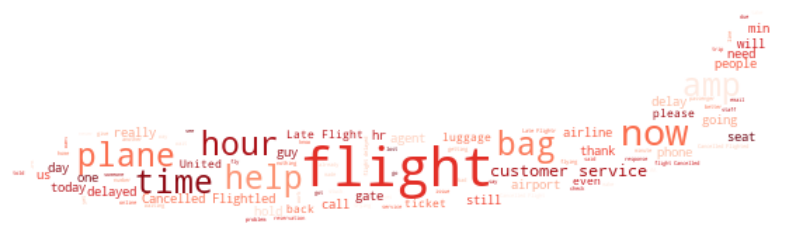

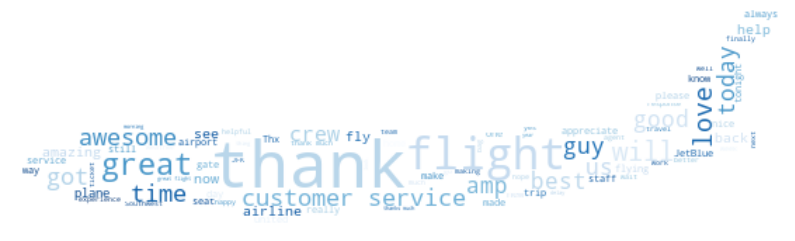

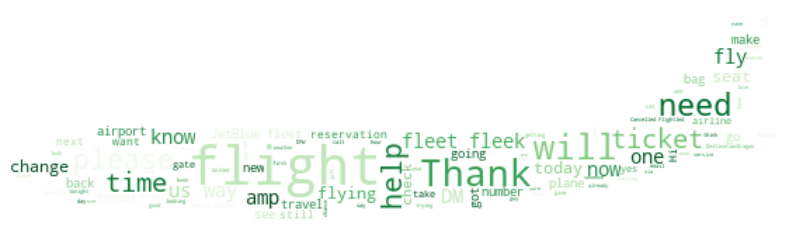

In [45]:
from wordcloud import WordCloud,STOPWORDS  #WordCloud is used for data visualization. The size of each word indicates its frequency or importance.
from PIL import Image # to import the image for the shape 
wave_mask = np.array(Image.open( "/content/airbus.jpg"))

#Positive sentiments
words_positive = ' '.join(tweets[tweets['airline_sentiment']=='positive']['text'])
cleaned_word_positive = " ".join([word for word in words_positive.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#Negative sentiments
words_negative = ' '.join(tweets[tweets['airline_sentiment']=='negative']['text'])
cleaned_word_negative = " ".join([word for word in words_negative.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
#Neutral sentiments
words_neutral = ' '.join(tweets[tweets['airline_sentiment']=='neutral']['text'])
cleaned_word_neutral = " ".join([word for word in words_neutral.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Reds",  width=3500, height=2500).generate(cleaned_word_negative)
plt.figure(1,figsize=(14, 14))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Blues", width=3500, height=2500).generate(cleaned_word_positive)
plt.figure(1,figsize=(14, 14))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Greens", width=3500, height=2500).generate(cleaned_word_neutral)
plt.figure(1,figsize=(14, 14))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [104]:
#Let's try to calculate the words with the highest prequency in tweets of each group of sentiments
from collections import Counter 

freq_negative = collections.Counter(cleaned_word_negative.split())
freq_positive = collections.Counter(cleaned_word_positive.split())
freq_neutral = collections.Counter(cleaned_word_neutral.split())

#Create dataframes in pandas with two columns and sort it by frequency
freq_negative = pd.DataFrame(freq_negative.most_common(50), columns=['words_negative', 'count'])
freq_negative.sort_values(ascending=False, by='count')

freq_positive = pd.DataFrame(freq_positive.most_common(50), columns=['words_positive', 'count'])
freq_positive.sort_values(ascending=False, by='count')

freq_neutral = pd.DataFrame(freq_neutral.most_common(50), columns=['words_neutral', 'count'])
freq_neutral.sort_values(ascending=False, by='count')

print('Negative \n', freq_negative.head(), '\n Positive \n', freq_positive.head(), '\n Neutral \n', freq_neutral.head())


Negative 
   words_negative  count
0             to   5966
1            the   3929
2              I   3375
3              a   3087
4            and   2685 
 Positive 
   words_positive  count
0            the    924
1             to    923
2            for    658
3              I    574
4            you    509 
 Neutral 
   words_neutral  count
0            to   1646
1             I   1105
2           the    928
3             a    771
4           you    631


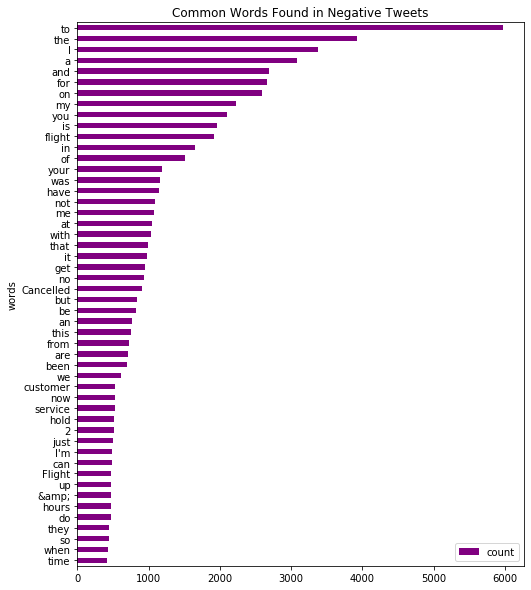

In [94]:
#Let's plot the results to check it visually
fig, ax = plt.subplots(figsize=(8, 10))

# Plot horizontal bar graph
freq_negative.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color="purple")
ax.set_title("Common Words Found in Negative Tweets")
plt.show()

###__Data Cleaning__

In [0]:
import re #Explain why import this?
import nltk #And this
nltk.download('stopwords')
from nltk.corpus import stopwords #And this and each function below

def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

tweets['clean_tweet']=tweets['text'].apply(lambda x: tweet_to_words(x))
tweets['Tweet_length']=tweets['text'].apply(lambda x: clean_tweet_length(x))
tweets['sentiment']=tweets['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#Split data into training and validation set
df_trn, df_val = train_test_split(tweets, stratify = tweets['airline_sentiment'], test_size = 0.4, random_state = 678) #Explain why 678

###__ULMFiT Model__


In [0]:
#Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.4) #explain

In [0]:
#Train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2) #Explain why this learning rate has been chosen

epoch,train_loss,valid_loss,accuracy,time
0,5.920623,4.275937,0.474256,00:36


In [0]:
#Unfreeze the learner object and train
learn.unfreeze()
learn.fit_one_cycle(7, slice(1e-2, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.505138,0.482198,0.810714,00:54
1,0.530932,0.489904,0.810863,00:54
2,0.515965,0.476172,0.811533,00:54
3,0.505761,0.469507,0.811533,00:54
4,0.498354,0.470698,0.810714,00:53
5,0.493418,0.469380,0.811161,00:54
6,0.489438,0.469218,0.811161,00:54


In [0]:
learn.save_encoder('ft_enc')